# Time Series Forecasting w/ VAR Vector Auto - regressif ¶

In [0]:
# import warnings
# warnings.filterwarnings("ignore")
# Compatibility between Python 2.7 and 3.x
# from __future__ import unicode_literals, print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import autocorrelation_plot
#style.use('fivethirtyeight')
#%matplotlib inline

import copy 
import math

import psycopg2

import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


## from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.layers import LSTM
# from keras import metrics
# from keras.wrappers.scikit_learn import KerasClassifier#

# Custom utility functions shared across notebooks
#import utils## Data Loading


!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [0]:
#Set up plot functions
import seaborn as sns

def plt_(dataset):    
    plt.figure(figsize=(12,6))
    plt.plot(dataset, color = 'b')
    plt.show()
    
def density_plt_(dataset):
    plt.figure(figsize=(12,6))
    sns.distplot(dataset)
    plt.show()
    
#Decomposition
def decomp_plt_(dataset):
    decomposition = seasonal_decompose(dataset)
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(dataset, label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'1Y1S3y59FTzcWn77uqkYzbSKBwkadIUEy' in parents and trashed=false"}).GetList() # id of colab notes in drive 
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id'])) # chose which csv u want to download

title: VAR-Vector Autoregressif Regression Model- TS  forecasting.ipynb, id: 1JMHHsj6KGhoiIQY4zqpqEx6rjWRd6e8l
title: Adaboost Regressor.ipynb, id: 1Brppd-4gLPDA_EAWcpaDuAGHo9wCDCjE
title: LSTM v3.ipynb, id: 1JD355WJ1tCmQxpklbvI0TZzvtoX-UMRG
title: Untitled3.ipynb, id: 1mdw0iGEJlF52DvSOYxDlt0HB1mjuued8
title: arima_time_series.ipynb, id: 13bqq0yCE4n-bmiAwZ0H9z7Ol7fDwmrhP
title: Untitled2.ipynb, id: 1-z5pjECgQgRjAukNQOUgzidoVfTUySUf
title: Stateful LSTM v3.ipynb, id: 16k84lrJtOJWJPEw-jR1CBswDn3TBHfh1
title: Untitled1.ipynb, id: 1Jct3IwUHmyGSxW0ljTdWTPgL546H6stC
title: Untitled, id: 1d0m5GkaV2IOz3qBkDCCHoNz09XzTql7U
title: VAR-Vector Autoregressif Regression Model- TS  forecasting.ipynb, id: 1iwZ1LAFdcOmniKM6uViWxzEKZUgrSphH
title: datapreprocess.py, id: 1C6H4Xw2PZ3VCjVxQ-xXBEiAhxC7VnL7h
title: Orig_data.csv, id: 1--v137MRLlIjs_RyjycDlQEn_dpzsq_p
title: Grouped_data_unfiltered.csv, id: 1--savgur5M36coH960hsPiQ3qJOC99u_
title: Orig_data.csv, id: 1nRr7SBfAT5MpPiyi5fXNyEGtogIyqXVK
title: fi

## Data Loading

In [0]:

# try:
#     connection = psycopg2.connect(user="sesyr",
#                                   password="SeSyR54",
#                                   host="51.254.68.36",
#                                   port="5432",
                  
#                                   database="donnees_trafic")
#     cursor = connection.cursor()

#     # Print PostgreSQL version
#     cursor.execute("SELECT version();")
#     record = cursor.fetchone()
#     print("You are connected to - ", record,"\n")
    
#     postgreSQL_select_Query = """
#     WITH metadata AS (
#           SELECT ist.macrosection,
#          ist.code_centrale,
#          cnl.code_canal,
#          sc.sens,
#          cc.id_nature_mesure, cc.libelle
#         FROM rdv.info_section_troncon ist
#         JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
#     JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
#     JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
#     JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%QT_360 %'::text
    
#     ), metadatavt AS (
#           SELECT distinct ist.macrosection,
#          ist.code_centrale,
#          cnl.code_canal,
#          sc.sens,
#          cc.id_nature_mesure, cc.libelle
#         FROM rdv.info_section_troncon ist
#         JOIN rdv.sens_canal sc ON sc.sens::text = ist.sens::text
#     JOIN myrabel.centrale c ON c.code_centrale = ist.code_centrale::bpchar
#     JOIN myrabel.canal cnl ON cnl.id_centrale = c.id_centrale AND cnl.code_canal::text = sc.canal::text
#     JOIN myrabel.cal_canal cc ON cc.id_canal = cnl.id_canal AND cc.libelle ~~ '%VT_360 %'::text
#     )
    
#     SELECT 
       
#        m.macrosection,
#        m.sens,
#        m.code_centrale,
#        m.code_canal, 
       
        
#        ts,
#        dq.valeur AS qt,
#        dv.valeur AS vt
       
       
#       FROM metadata  m
#       JOIN metadatavt v
#       ON m.macrosection = v.macrosection AND m.sens = v.sens AND m.code_centrale = v.code_centrale AND  m.code_canal=  v.code_canal
      
#       CROSS JOIN generate_series('2016-05-01' , '2017-05-30','01:00:00'::interval) AS  ts(ts)
      
#       LEFT JOIN myrabel.mesure_2 dq    
#       ON dq.id_nature_mesure = m.id_nature_mesure
#       AND dq.date_mesure = ts 
      
#         LEFT JOIN myrabel.mesure_2 dv    
#       ON dv.id_nature_mesure = v.id_nature_mesure
#       AND dv.date_mesure = ts
      
      
#         --WHERE(  dv.date_mesure IS NULL OR dq.date_mesure IS NULL OR dv.date_mesure = dq.date_mesure )
      
#      -- WHERE dq.date_mesure IS NOT  NULL AND dv.date_mesure IS NULL  --OR dq.date_mesure IS NULL
      
#       """
    

#     cursor.execute(postgreSQL_select_Query)
#     print("Selecting rows from mobile table using cursor.fetchall")
#     records = cursor.fetchall() 
   
#    # print("Print each row and it's columns values")
#    #for row in records:
#        #   print("Macrosection = ", row[0])
#         #  print("sens = ", row[1])
#          # print("code centrale   = ", row[2])
#           #print(" code canal = ", row[3])
#         #  print("date_mesure = ", row[4])
#          # print("qt_360 = ", row[5]) 
#           #print("Vt_360 = ", row[6],"\n" )
            
            
# except (Exception, psycopg2.Error) as error :
#     print ("Error while connecting to PostgreSQL", error)
        
# finally:
#     #closing database connection.
#         if(connection):
#             cursor.close()
#             connection.close()
#             print("PostgreSQL connection is closed")            

In [0]:
file_name= drive.CreateFile({'id': '1--v137MRLlIjs_RyjycDlQEn_dpzsq_p'})
file_name.GetContentFile('Orig_data.csv')

df = pd.read_csv('Orig_data.csv') #2018-10-07 22:00:00+00:00	

df = df.drop(df.columns[0],axis = 1)



# # df['cos_Feature_hour']=np.sin(2.*np.pi*df_hours_float/24.)
# # df['sin_Feature_hour']=np.cos(2.*np.pi*df_hours_float/24.)

# #df= df.set_index('date')

# df = df.drop(["sens", "Macrosection"], axis=1)
# #df = df.replace(0,np.NaN) # np.NaN ca va marcher , np.nan doesnt work anymore !!
# df['vt_360'] = df['vt_360'].replace(0,np.NaN)
# df['qt_360'] = df['qt_360'].replace(0,np.NaN)

df = df.drop(["cos_Feature_hour" ,"sin_Feature_hour" ],axis = 1)


df.head()

,code_centrale,code_canal,date,qt_360,vt_360
0,MZE54.3,0,2015-12-31 23:00:00+00:00,15.0,98.0
1,MZE54.3,0,2016-01-01 00:00:00+00:00,11.0,105.0
2,MZE54.3,0,2016-01-01 01:00:00+00:00,24.0,110.0
3,MZE54.3,0,2016-01-01 02:00:00+00:00,51.0,109.0
4,MZE54.3,0,2016-01-01 03:00:00+00:00,31.0,106.0


In [0]:
DataFrameDict=df.groupby(['code_canal','code_centrale'])
    
#print to s
for key, item in DataFrameDict:
    print(DataFrameDict.get_group(key), "\n\n")
    #print (key)
    #DataFrameDict.get_group(key).to_csv(r'C:\Users\hp\Desktop\Stage IOT TS\devellopement\grouping_by_codes'+ str(key) +'.csv')   


      code_centrale  code_canal   ...   qt_360  vt_360
0           MZE54.3           0   ...     15.0    98.0
1           MZE54.3           0   ...     11.0   105.0
2           MZE54.3           0   ...     24.0   110.0
3           MZE54.3           0   ...     51.0   109.0
4           MZE54.3           0   ...     31.0   106.0
5           MZE54.3           0   ...     24.0   102.0
6           MZE54.3           0   ...     28.0   102.0
7           MZE54.3           0   ...      9.0   102.0
8           MZE54.3           0   ...      9.0   108.0
9           MZE54.3           0   ...     16.0   103.0
10          MZE54.3           0   ...     35.0   108.0
11          MZE54.3           0   ...     58.0   108.0
12          MZE54.3           0   ...    108.0   109.0
13          MZE54.3           0   ...     74.0   109.0
14          MZE54.3           0   ...    100.0   110.0
15          MZE54.3           0   ...    107.0   111.0
16          MZE54.3           0   ...    135.0   110.0
17        

In [0]:
# for k, v in DataFrameDict:
#       ax=DataFrameDict.get_group(k).plot(figsize =(22,10))
#       ax.set_ylabel(k)

In [0]:
group = [0]*len(DataFrameDict)
for i, (k, v) in enumerate(DataFrameDict):
    group[i] = DataFrameDict.get_group(k)

In [0]:
for i in range(len(group)):
      group[i] = group[i].drop(["code_centrale", "code_canal"], axis=1)

#delete  12 because has almots null data


In [0]:
merged = group[0]
for i in range(len(group)-1):
      merged = pd.merge(merged,group[i+1], on='date',how ='left')



In [0]:
merged.columns = ['date',
                  'qt_dv00', 'vt_dv00',
                  'qt_dv01', 'vt_dv01',
                  'qt_dv02', 'vt_dv02',
                  'qt_dv03', 'vt_dv03', 
                  'qt_dv04', 'vt_dv04',
                  
                  'qt_dv05', 'vt_dv05',
                  'qt_dv06', 'vt_dv06',
                  'qt_dv07', 'vt_dv07',
                  'qt_dv08', 'vt_dv08',
                  
                  'qt_dv09', 'vt_dv09',
                  'qt_dv10', 'vt_dv10', 
                  'qt_dv11', 'vt_dv11',
                  'qt_dv12', 'vt_dv12', 
                  'qt_dv13', 'vt_dv13',
                  
                  'qt_dv14', 'vt_dv14',
                  'qt_dv15', 'vt_dv15',
                  'qt_dv16', 'vt_dv16', 
                  'qt_dv17', 'vt_dv17',
                  'qt_dv18', 'vt_dv18',
                  'qt_dv19', 'vt_dv19', 
                  
                  'qt_dv20', 'vt_dv20',
                  'qt_dv21', 'vt_dv21',
                  'qt_dv22', 'vt_dv22',
                  'qt_dv23', 'vt_dv23',
                  'qt_dv24', 'vt_dv24',
                  'qt_dv25', 'vt_dv25', 
                  'qt_dv26', 'vt_dv26'
                  
#                   'cos_Feature_hour',
#                   'sin_Feature_hour'
            ]

merged.columns

Index(['date', 'qt_dv00', 'vt_dv00', 'qt_dv01', 'vt_dv01', 'qt_dv02',
       'vt_dv02', 'qt_dv03', 'vt_dv03', 'qt_dv04', 'vt_dv04', 'qt_dv05',
       'vt_dv05', 'qt_dv06', 'vt_dv06', 'qt_dv07', 'vt_dv07', 'qt_dv08',
       'vt_dv08', 'qt_dv09', 'vt_dv09', 'qt_dv10', 'vt_dv10', 'qt_dv11',
       'vt_dv11', 'qt_dv12', 'vt_dv12', 'qt_dv13', 'vt_dv13', 'qt_dv14',
       'vt_dv14', 'qt_dv15', 'vt_dv15', 'qt_dv16', 'vt_dv16', 'qt_dv17',
       'vt_dv17', 'qt_dv18', 'vt_dv18', 'qt_dv19', 'vt_dv19', 'qt_dv20',
       'vt_dv20', 'qt_dv21', 'vt_dv21', 'qt_dv22', 'vt_dv22', 'qt_dv23',
       'vt_dv23', 'qt_dv24', 'vt_dv24', 'qt_dv25', 'vt_dv25', 'qt_dv26',
       'vt_dv26'],
      dtype='object')

In [0]:
def get_non_null(df):
    lngth = min(list(len(col.dropna()) for ind, col in df.iteritems()))
    df = pd.concat(list(df.loc[:,col].dropna().head(lngth).reset_index(drop=True) for col in df),axis=1)
    return df

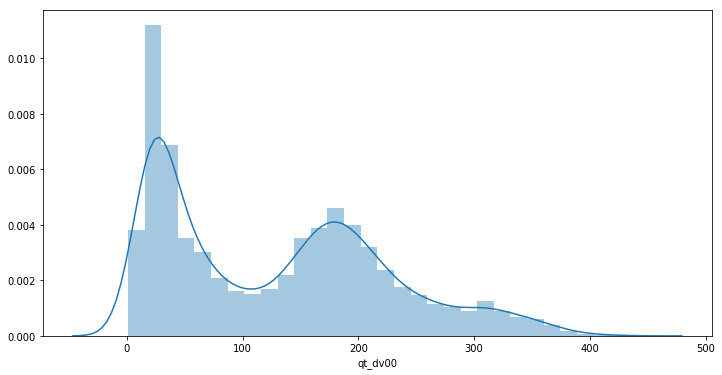

In [0]:
# take the data witn Non NaN values the data is adapted in the least number of a column

filtered_df = get_non_null(merged)

date = copy.deepcopy(filtered_df.date) 

filtered_df = filtered_df.set_index("date")

Dataset = filtered_df

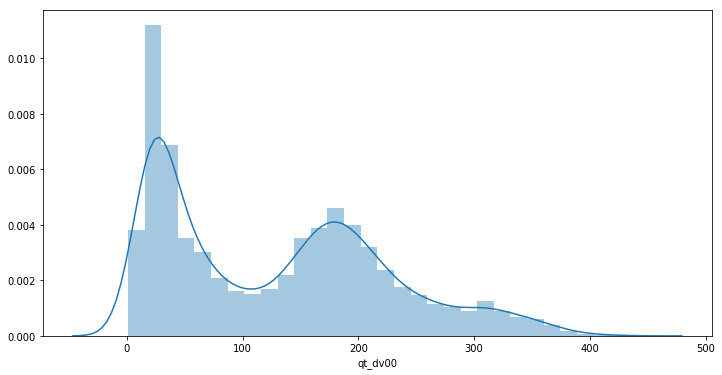

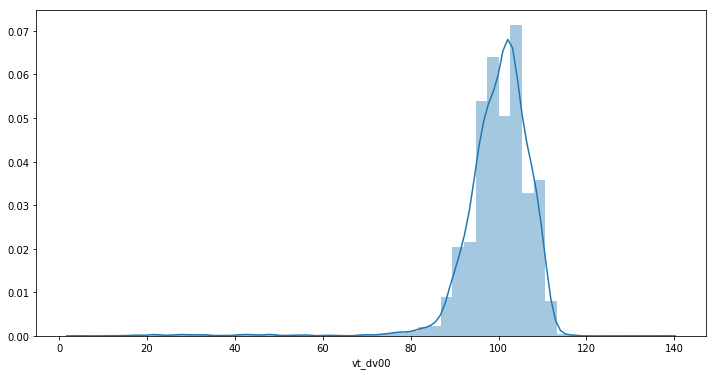

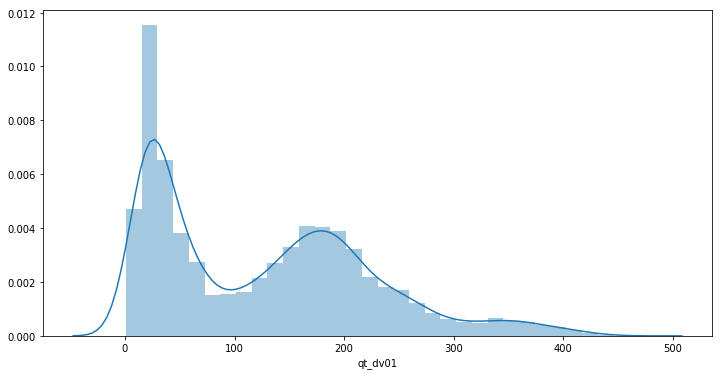

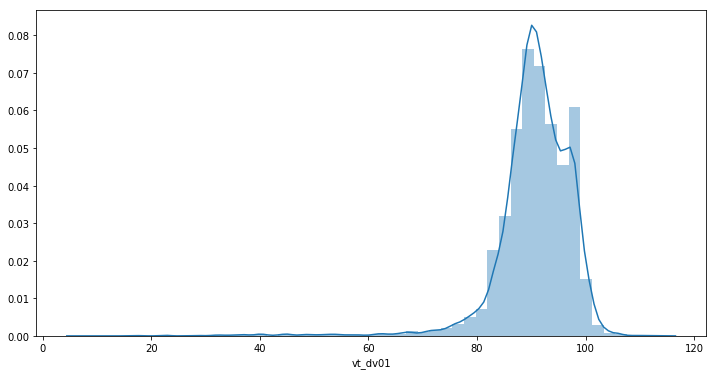

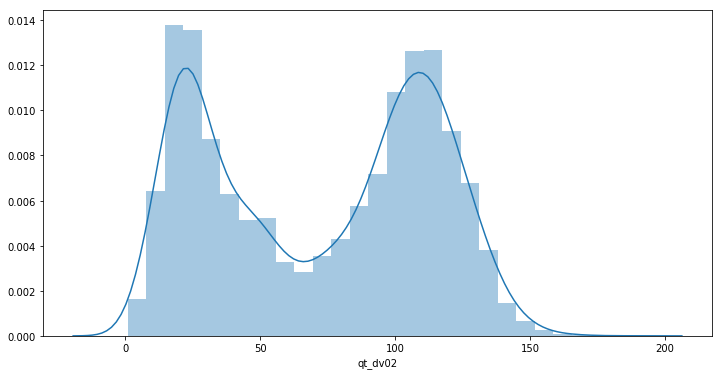

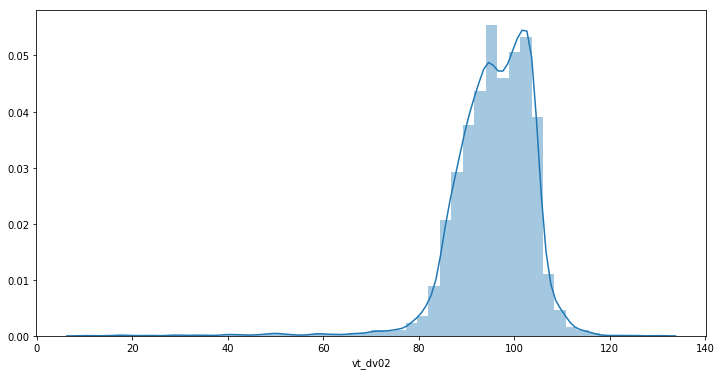

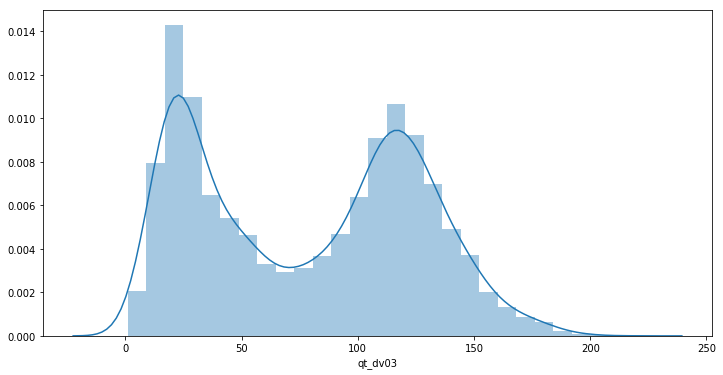

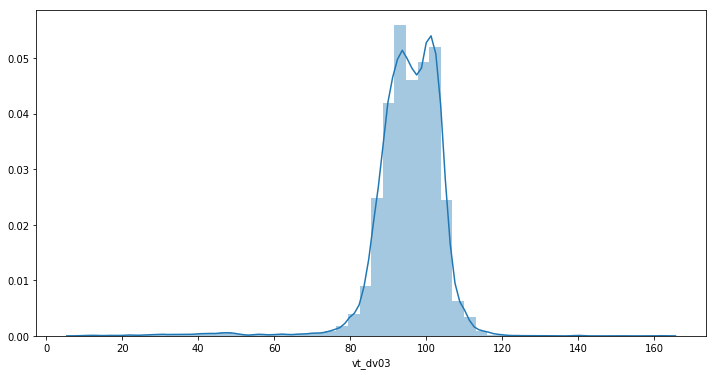

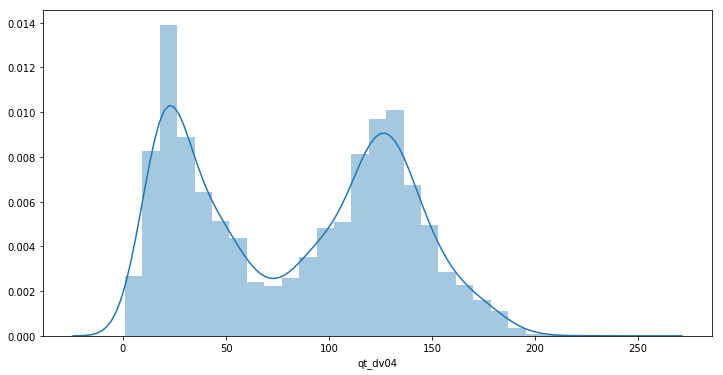

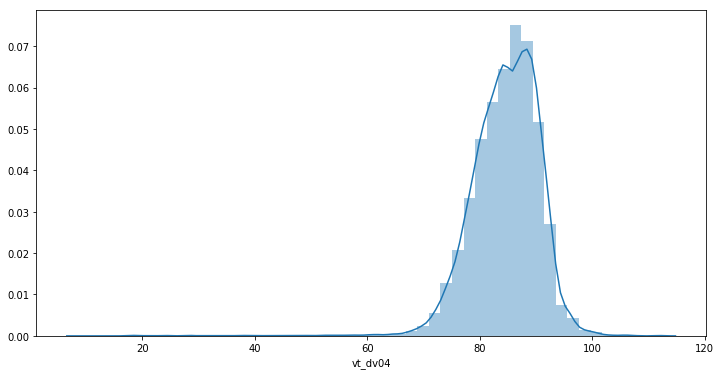

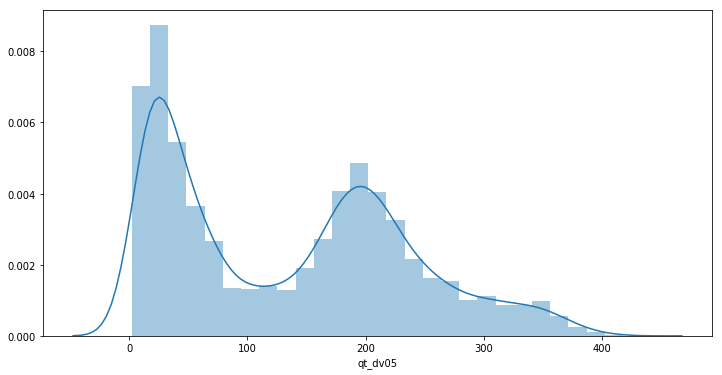

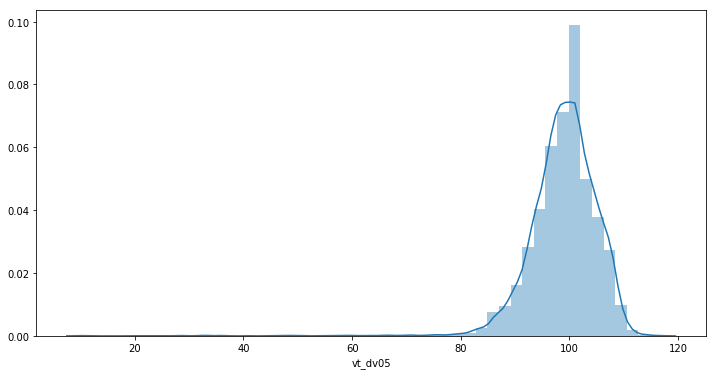

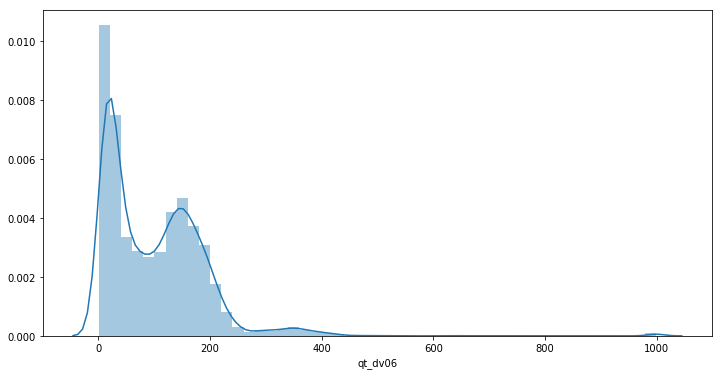

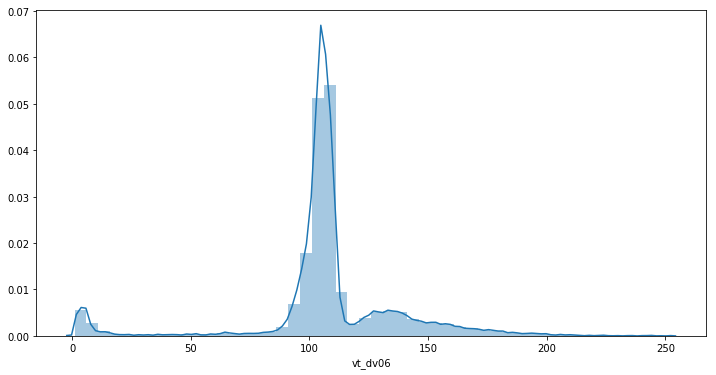

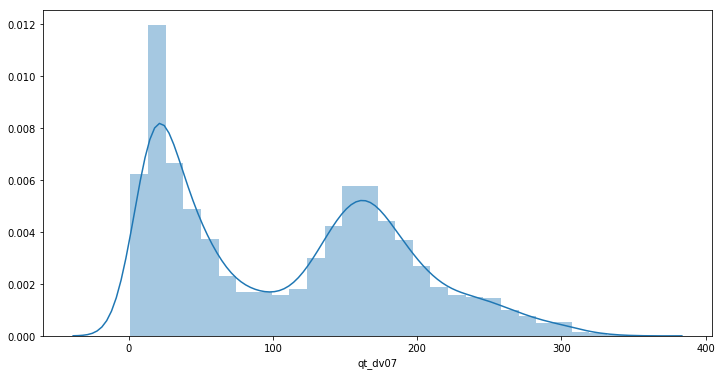

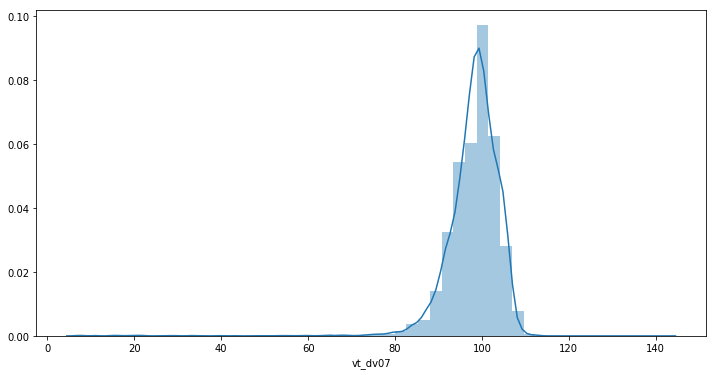

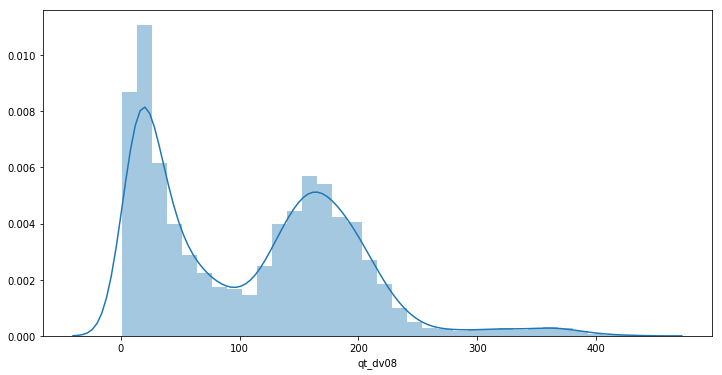

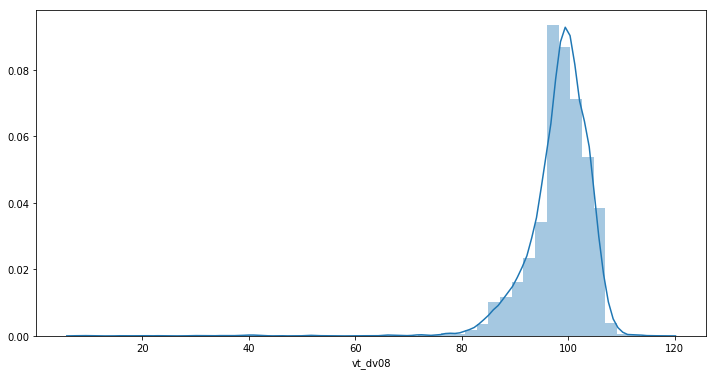

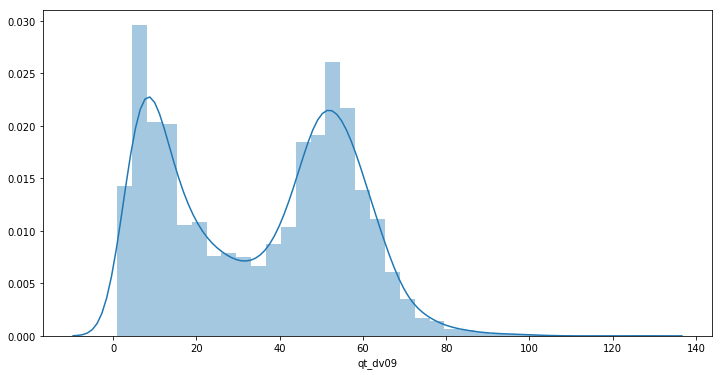

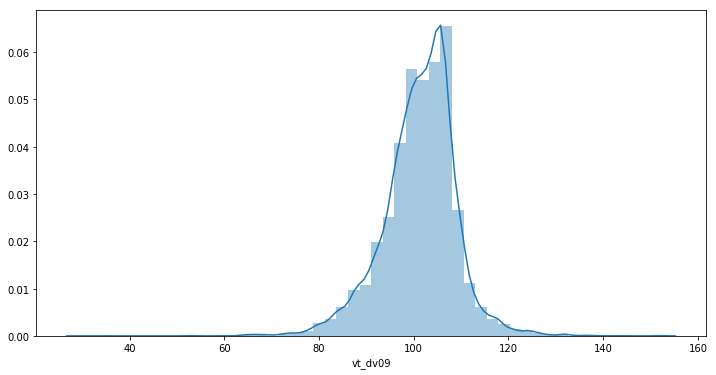

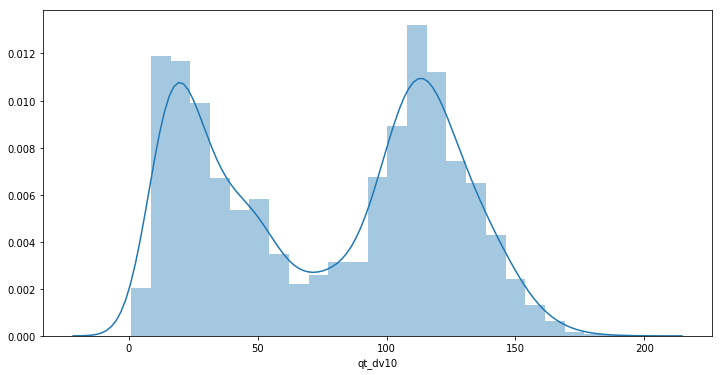

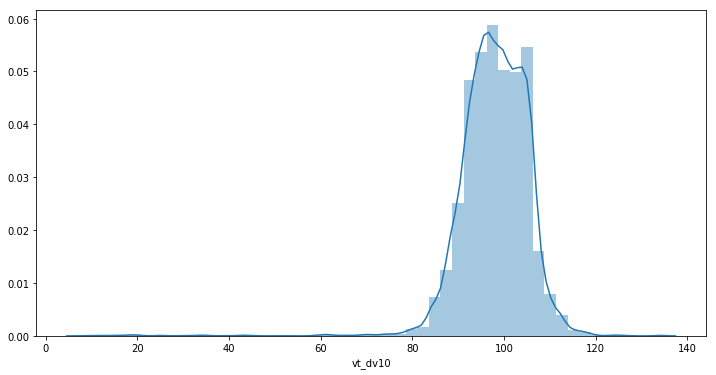

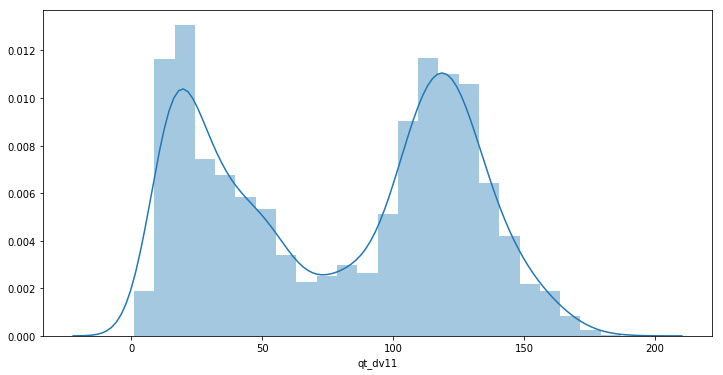

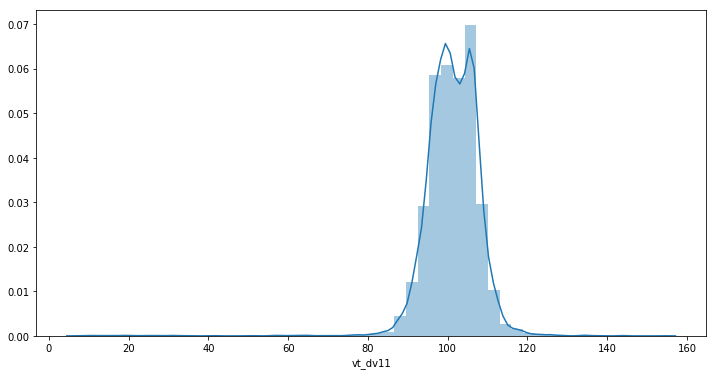

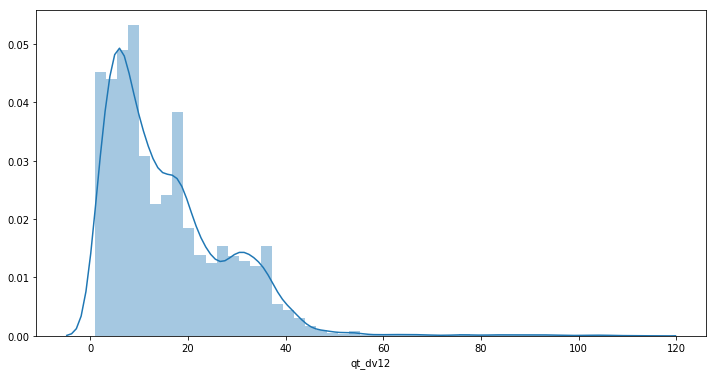

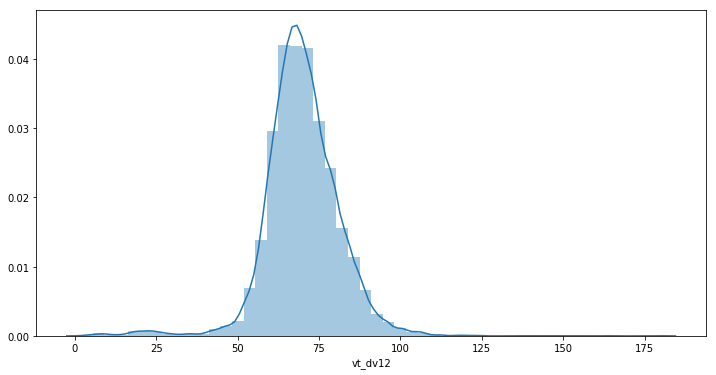

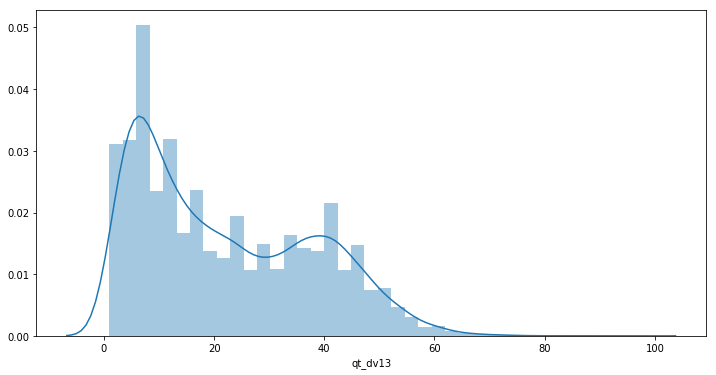

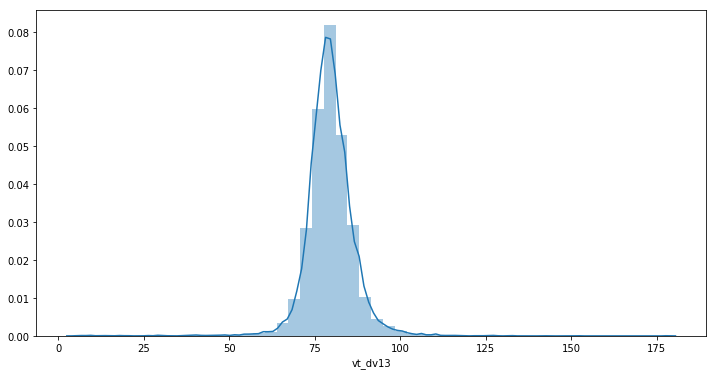

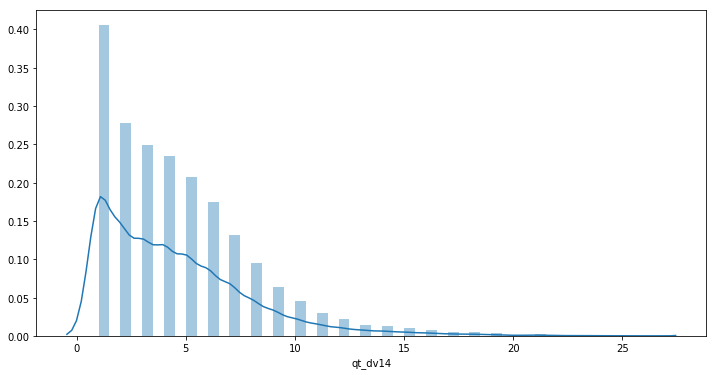

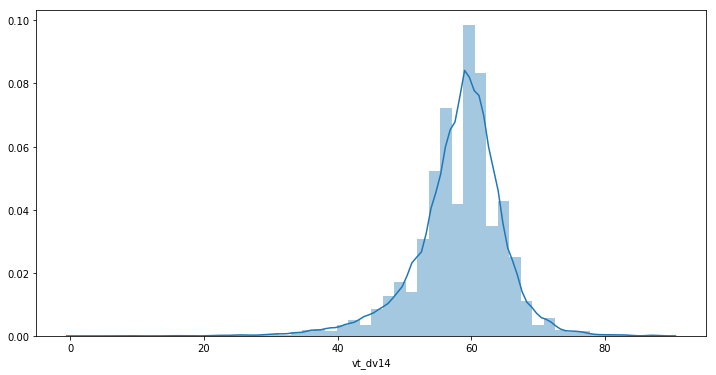

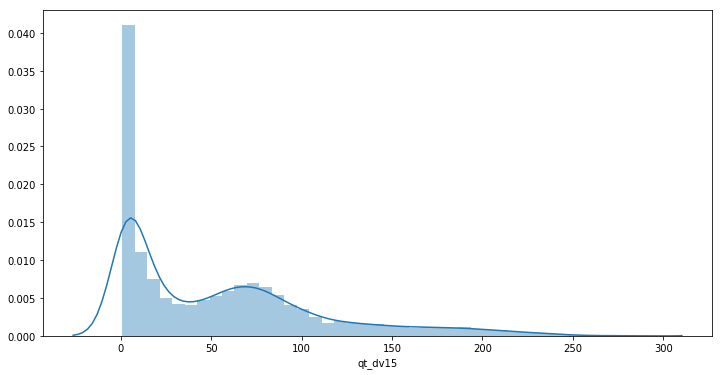

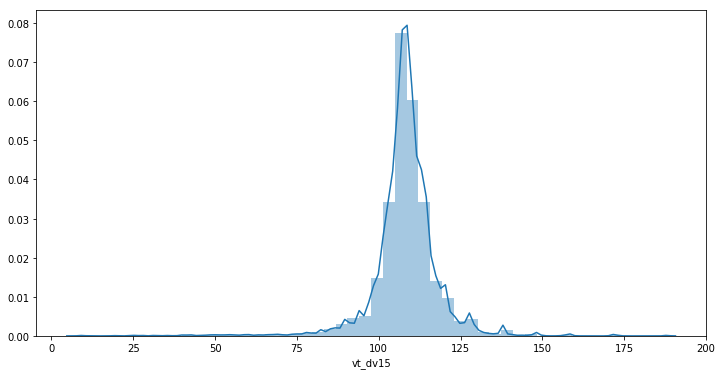

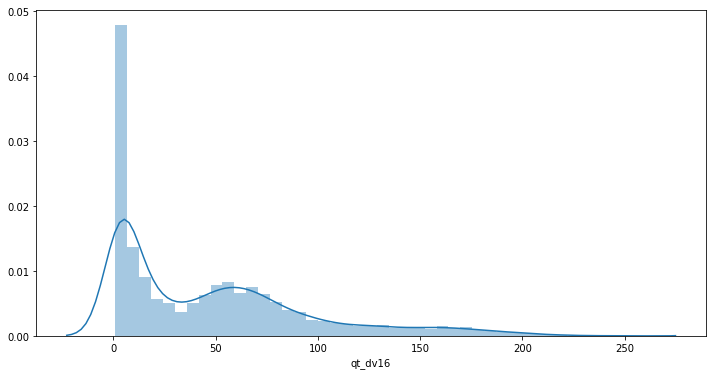

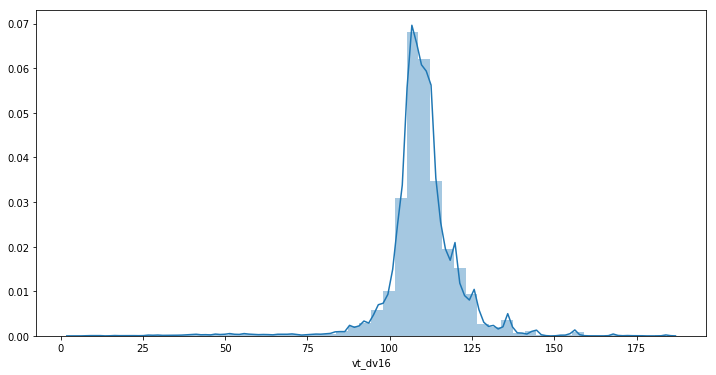

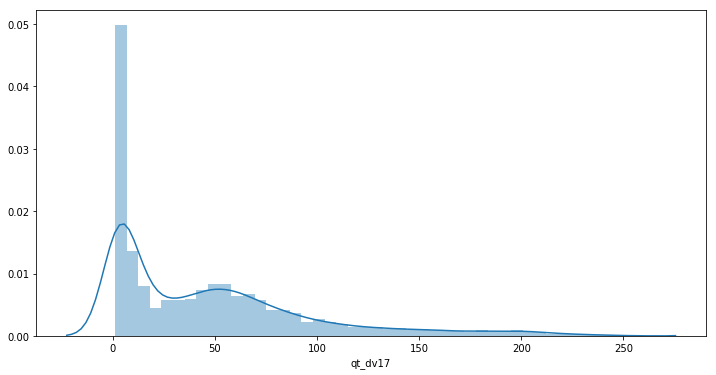

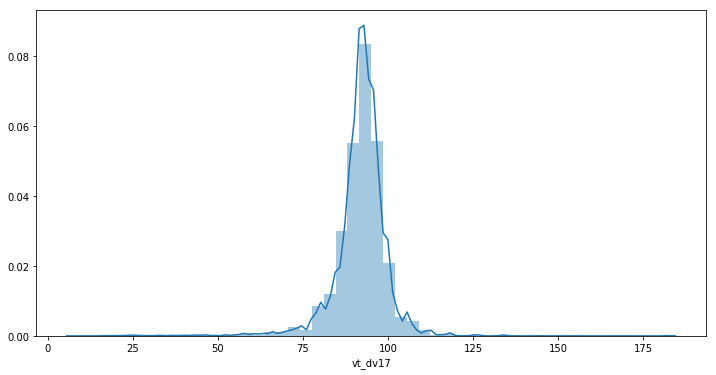

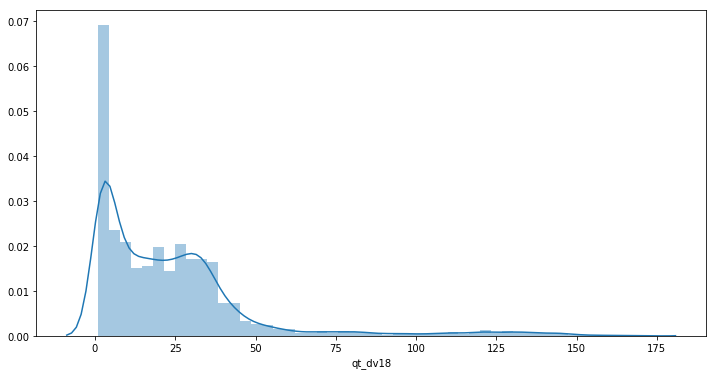

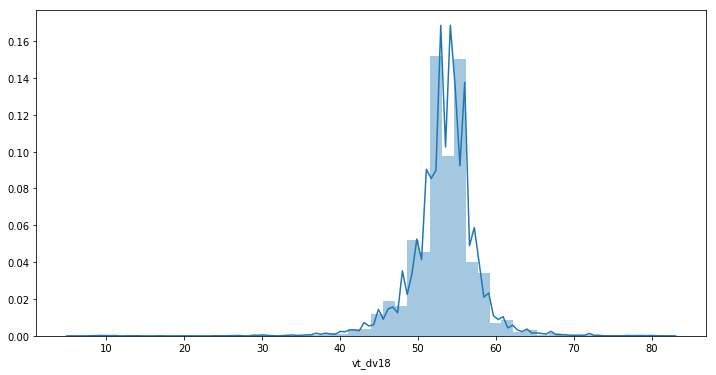

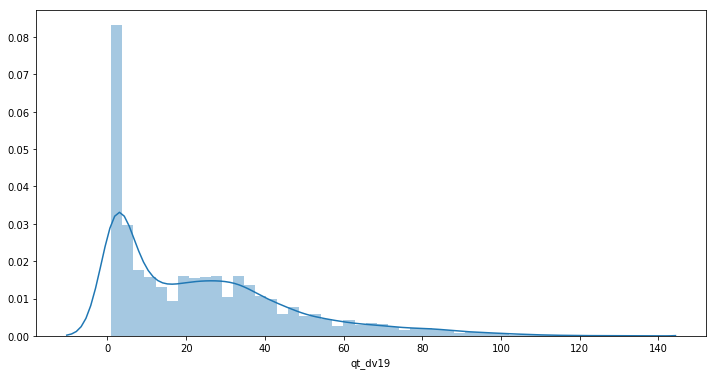

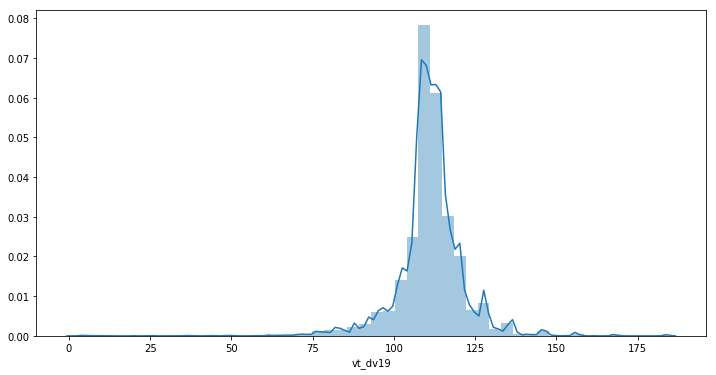

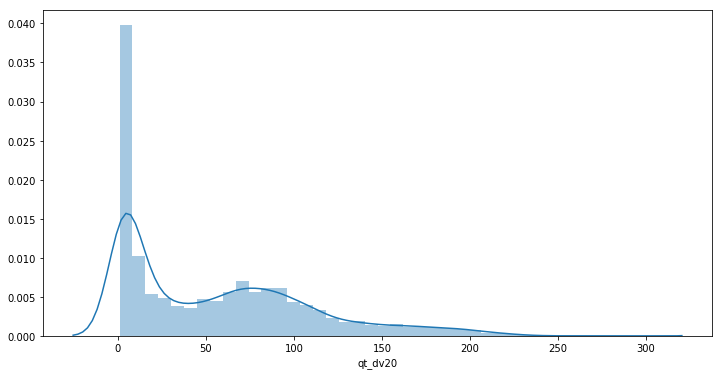

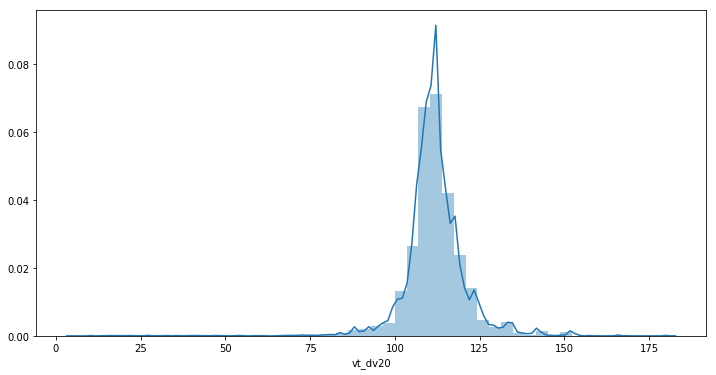

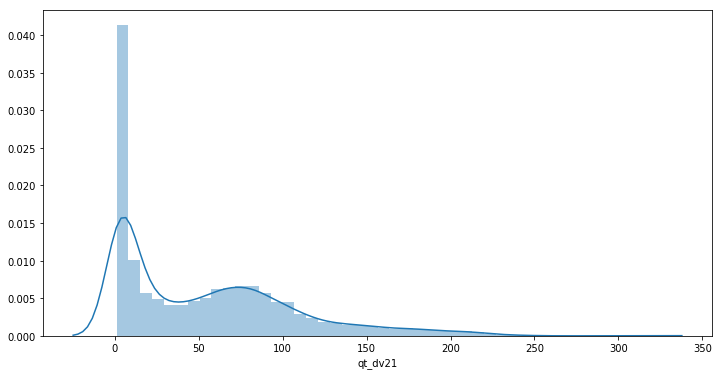

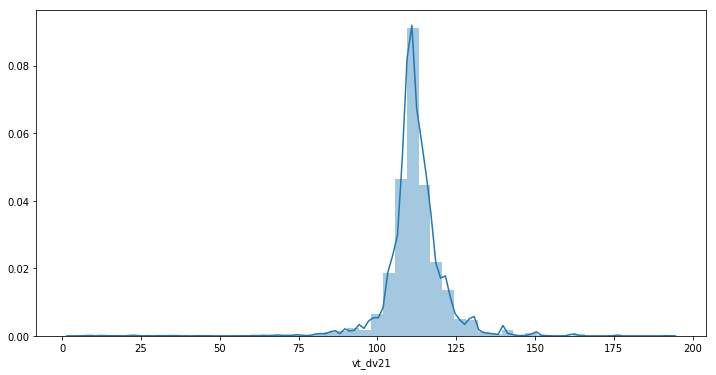

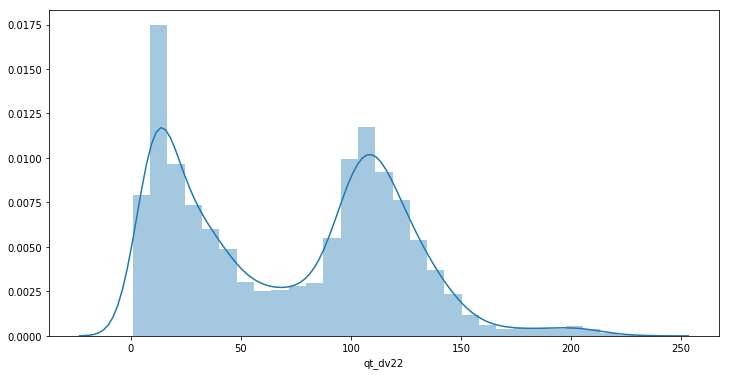

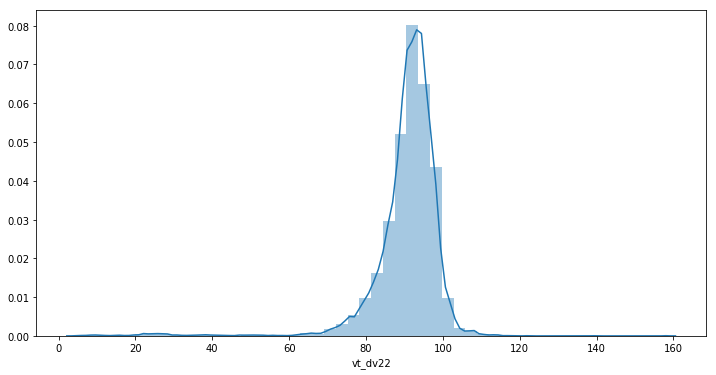

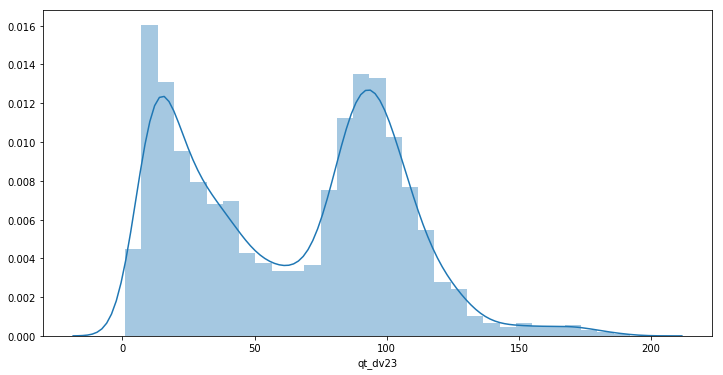

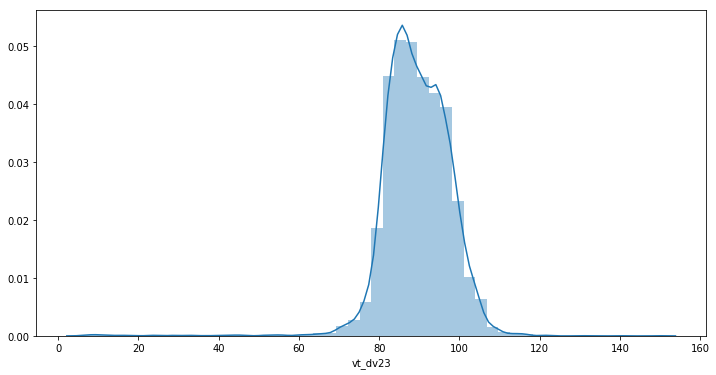

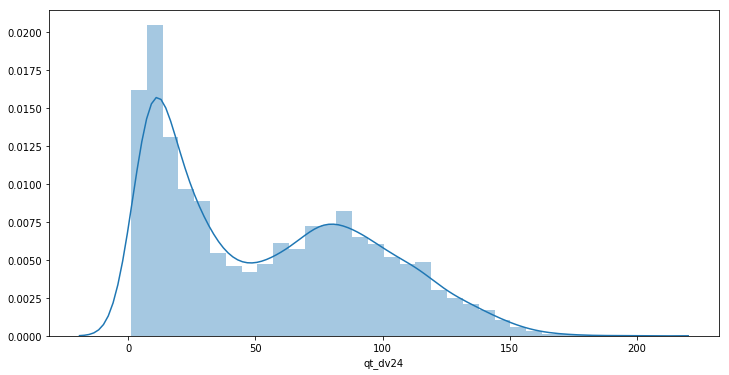

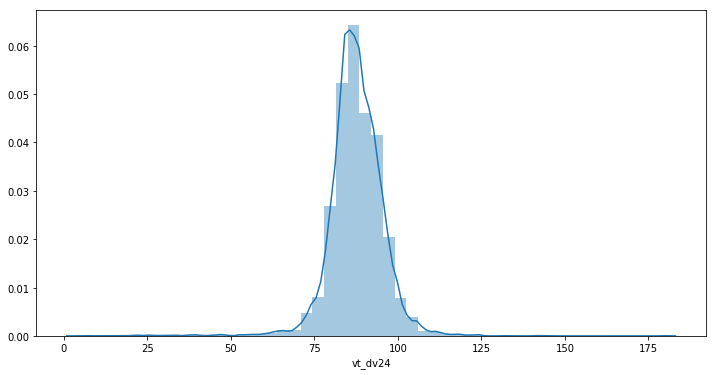

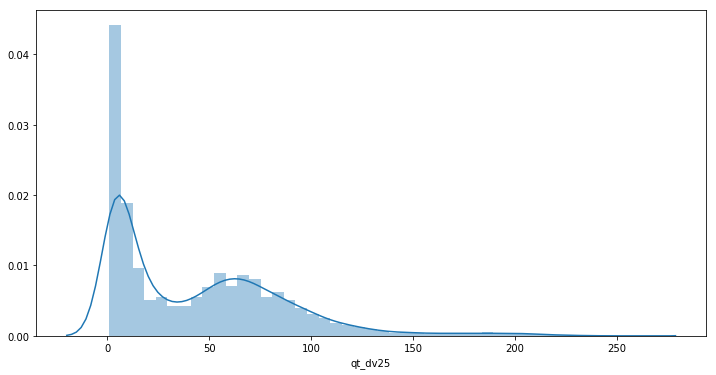

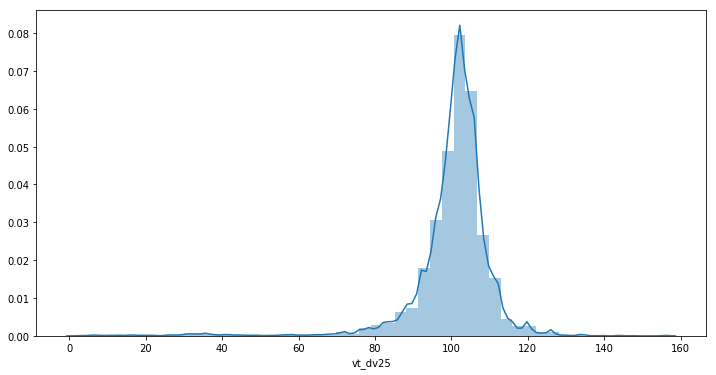

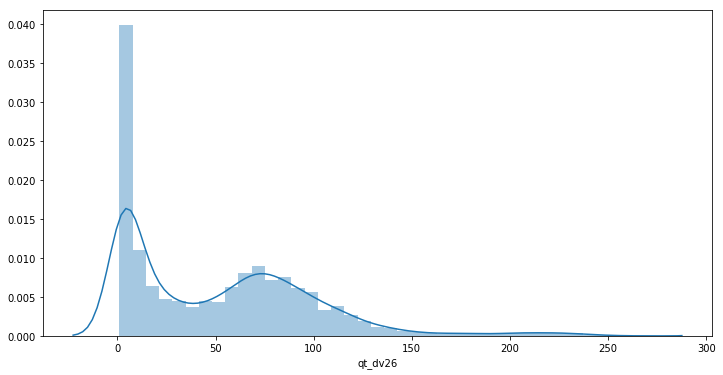

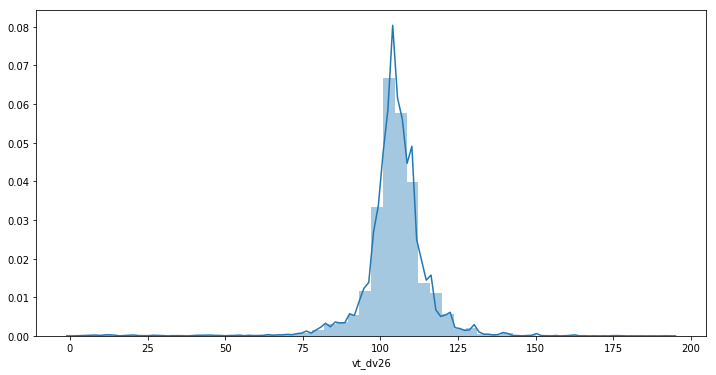

In [0]:
for i in Dataset.columns:
    density_plt_(Dataset[i])

### Check for stationarity :

What is meant by checking the stationarity of a time series and why do you care about it?

In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. Normally, when running a regular regression, you expect the observations to be independent of each other. In a time series, however, you know that the observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. The techniques that apply to independent random variables also apply to stationary random variables.

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary. If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.

Calculate the moving variances, plot the results and apply the Dickey-Fuller test on the time series:

In [0]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=52,center=False).mean() 
    rolling_std = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    plt.figure(num=1, figsize=(20, 15), dpi=80)

    original = plt.plot(timeseries.index, timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index, rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index, rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)
    

In [0]:
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

# init bokeh
output_notebook()

def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth = pd.Series(truth, index=np.arange(truth.shape[0]))
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=600, plot_width=900, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth.index, truth.values, color=c1, legend='Observed')
    p.line(forecasts.index, forecasts.values, color=c2, legend='Forecasted')
    
    return p

Loading BokehJS ...

In [0]:
d = Dataset.reset_index(drop=True)

train = d.iloc[0:int(len(d)*0.8),:]
test = d.iloc[int(len(d)*0.8):, :]

train = train[['qt_dv02','qt_dv04']]
test = test [[ 'qt_dv02','qt_dv04']]
# train.drop(labels = ['vt_dv00','vt' , ,'qt_dv01','vt_dv01', 'vt_dv00', ],axis = 1 , inplace= True)

# print(train.head())


print(test.head())

# test.reset_index(drop=True,inplace=True)

print(test.head())

print('number of training  rows :{}  '.format(np.shape(train)),'\n')
print('number of training  rows :{}  '.format(np.shape(test)),'\n')

# # #checking stationarity in test dataset eigenvalue should be less than 1
from statsmodels.tsa.vector_ar.vecm import coint_johansen

coint_johansen(train,-1,1).eig

      qt_dv02  qt_dv04
9273    119.0      9.0
9274    111.0     11.0
9275    113.0     17.0
9276    115.0     25.0
9277     69.0     35.0
      qt_dv02  qt_dv04
9273    119.0      9.0
9274    111.0     11.0
9275    113.0     17.0
9276    115.0     25.0
9277     69.0     35.0
number of training  rows :(9273, 2)   

number of training  rows :(2319, 2)   



array([0.09041871, 0.01297847])

In [0]:
#checking stationarity in test dataset eigenvalue should be less than 1
coint_johansen(test,-1,1).eig

array([0.12203995, 0.01430394])

data is indeed stationary

In [0]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train.values )
model_fit = model.fit(maxlags=24)

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(test))



In [0]:
#converting predictions to dataframe
ind = merged.columns.drop('date')

ind = ['qt_dv02','qt_dv04'] 

pred = pd.DataFrame(index= range( np.shape(train)[0], np.shape(train)[0]+ len(test) ),columns=[ind])

for j in range(0,len(ind)):
    for i in range(0, np.shape(test)[0]):
        pred.iloc[i][j] = prediction[i][j]

pred

,qt_dv02,qt_dv04
9273,129.048,9.22684
9274,125.803,14.6698
9275,120.09,27.3653
9276,105.277,50.2178
9277,90.6273,77.086
9278,73.3108,105.767
9279,59.5503,129.699
9280,45.4165,144.43
9281,37.9921,145.178
9282,31.7938,148.621


In [0]:
#check rmse
  for i in ind :  
        print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], test[i])))
     
plt.figure(figsize=(15,13))
#plt.plot(train.index, train['qt_dv00'], label='Train')
plt.plot(test.index, test['qt_dv00'], label='Test')
plt.plot( pred['qt_dv00'], label='Predicted')
plt.show()

len(pred) 

rmse value for qt_dv02 is :  41.43875187061286
rmse value for qt_dv04 is :  45.01655268668165


KeyError: ignored

<Figure size 1080x936 with 0 Axes>

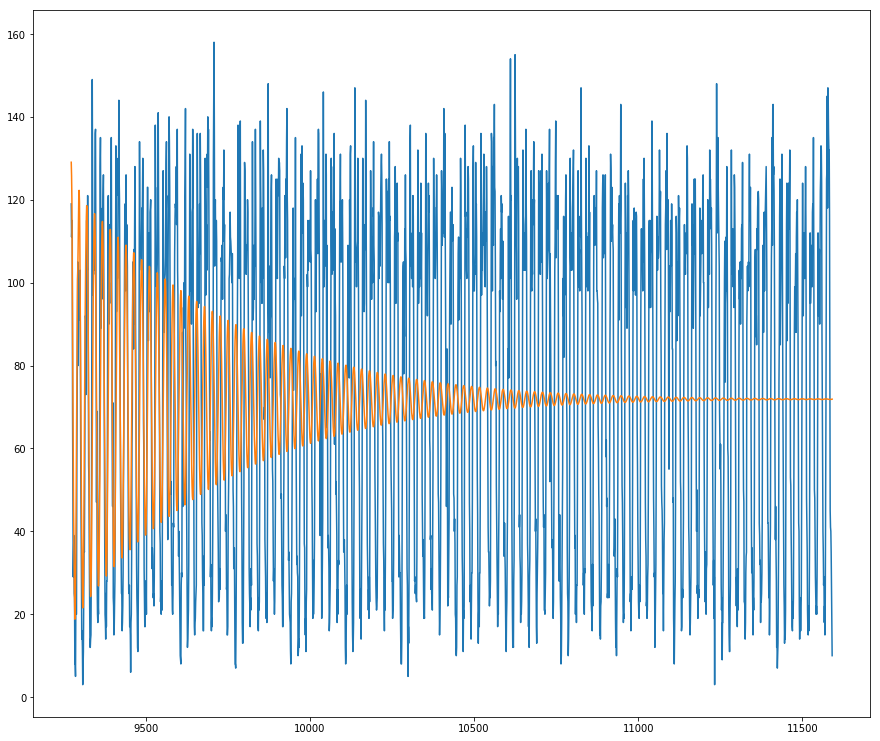

In [0]:
     
plt.figure(figsize=(15,13))
#plt.plot(train.index, train['qt_dv00'], label='Train')
plt.plot(test.index, test['qt_dv02'], label='Test')
plt.plot( pred['qt_dv02'], label='Predicted')
plt.show()

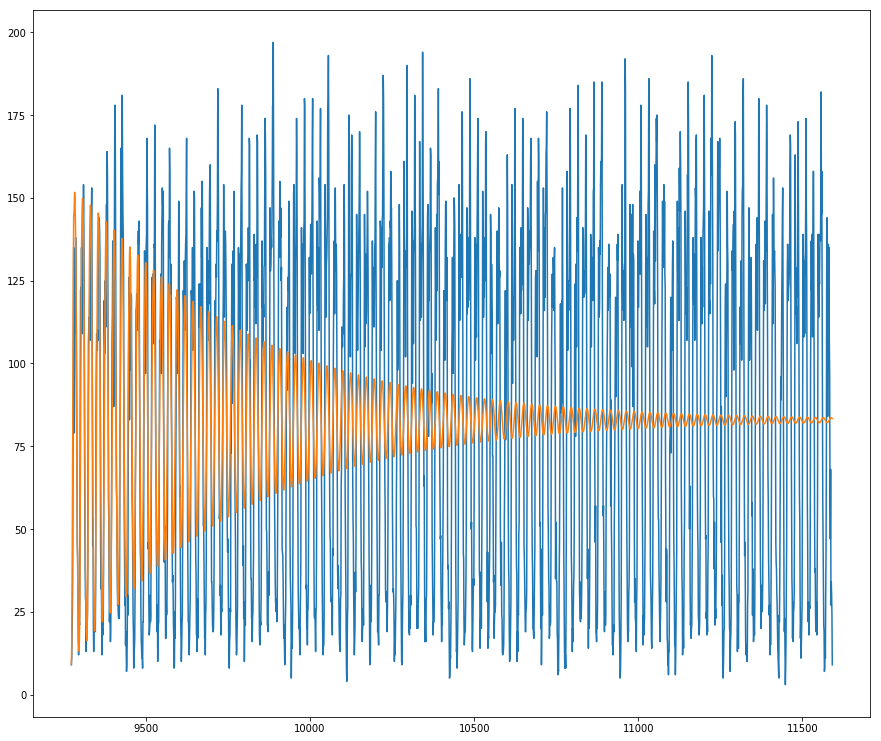

In [0]:
     
plt.figure(figsize=(15,13))
#plt.plot(train.index, train['qt_dv00'], label='Train')
plt.plot(test.index, test['qt_dv04'], label='Test' )
                          
plt.plot( pred['qt_dv04'], label='Predicted')
plt.show()